In [7]:
%matplotlib inline
from start_plot import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sigmaclip
import emcee

#  Read in the RV results from 14 exposures 
 for every two exposures, make a pair to get
v1-v2 
&
the error of (v1-v2),
in order to calculate the systematic floor

In [4]:
#appen = '_scale_error0.7'
appen = ''
#medusa1
tab1=np.genfromtxt('HorI_rv/HorI_1'+str(appen)+'.txt', names=True, dtype=None)
tab2=np.genfromtxt('HorI_rv/HorI_2'+str(appen)+'.txt', names=True, dtype=None)
tab3=np.genfromtxt('HorI_rv/HorI_3'+str(appen)+'.txt', names=True, dtype=None)
tab4=np.genfromtxt('HorI_rv/HorI_4'+str(appen)+'.txt', names=True, dtype=None)
tab5=np.genfromtxt('HorI_rv/HorI_5'+str(appen)+'.txt', names=True, dtype=None)
tab6=np.genfromtxt('HorI_rv/HorI_6'+str(appen)+'.txt', names=True, dtype=None)
tab7=np.genfromtxt('HorI_rv/HorI_7'+str(appen)+'.txt', names=True, dtype=None)
tab8=np.genfromtxt('HorI_rv/HorI_8'+str(appen)+'.txt', names=True, dtype=None)

#medusa2
tab9=np.genfromtxt('HorI_rv/HorI_9'+str(appen)+'.txt', names=True, dtype=None)
tab10=np.genfromtxt('HorI_rv/HorI_10'+str(appen)+'.txt', names=True, dtype=None)
tab11=np.genfromtxt('HorI_rv/HorI_11'+str(appen)+'.txt', names=True, dtype=None)
tab12=np.genfromtxt('HorI_rv/HorI_12'+str(appen)+'.txt', names=True, dtype=None)
tab13=np.genfromtxt('HorI_rv/HorI_13'+str(appen)+'.txt', names=True, dtype=None)
tab14=np.genfromtxt('HorI_rv/HorI_14'+str(appen)+'.txt', names=True, dtype=None)

tab_all = [(tab1, tab2, tab3, tab4, tab5, \
          tab6, tab7, tab8, tab9, tab10, \
          tab11, tab12, tab13, tab14)]
        
nexp = 14


In [33]:
diff=[]
differr=[]

th = 50
k = 0
for k in range(0,nexp):
    for i in tab_all:
        for ii in i[k]:
            id = ii['catalog_id']
            for j in tab_all:
                for jj in j[k+1:]:
                    for jjj in jj:
                        if jjj['catalog_id'] == id:
                            #print ii
                            #print jjj
                            if abs(ii['rv']- jjj['rv']) < th and ii['snr'] > 2:
                                diff.append(ii['rv']- jjj['rv'])
                                differr.append(np.sqrt(ii['rverr']**2+jjj['rverr']**2))
                                #print id, ii['rv'], jjj['rv'], ii['rverr'], jjj['rverr'], ii['template'], jjj['template'], ii['snr'], jjj['snr']

print len(diff)

2959


## Use a maximum likelyhood approach to get the systematic floor = 0.3 km/s

In [9]:
def log_prior(theta, x):
    sigma2, mu = theta
    if  sigma2 < 0:
        return -np.inf
    #if not x.min() < mu < x.max():
    #    return -np.inf

    return 0 #1

def log_likelihood(theta, x, x_err):
    sigma2, mu = theta
    #print(theta)

    # break long equation into three parts
    a = -0.5 * np.sum(np.log(x_err**2 + 2*sigma2))  # 2 times sigma here bcz it's v1-v2's error
    b = -0.5 * np.sum((x - mu)**2/(x_err**2 + 2*sigma2))
    c = -1. * (x.size)/2. * np.log(2*np.pi)

    return a + b + c

def log_posterior(theta, x, x_err):
    lp = log_prior(theta, x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, x_err)

def std_err_cal(x, x_err):
    ndim = 2  # number of parameters in the model
    nwalkers = 20  # number of MCMC walkers
    nburn = 50  # "burn-in" period to let chains stabilize
    nsteps = 1000  # number of MCMC steps to take
    
    m = np.random.normal(np.mean(x), scale=1, size=(nwalkers))
    s = np.random.normal(np.std(x), scale=1, size=(nwalkers))
    starting_guesses = np.vstack([s,m]).T
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x,x_err], threads=1)
    sampler.run_mcmc(starting_guesses, nsteps)
    samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
    sigma_rec, mean_rec = map(lambda v: (np.sqrt(v[1]), np.sqrt(v[2])-np.sqrt(v[1]), np.sqrt(v[0])-np.sqrt(v[1])), \
                              zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    v = np.percentile(samples[:,1], [16, 50, 84])
    mean_rec = (v[1], v[2]-v[1], v[0]-v[1])
    v = np.percentile(samples[:,0], [16, 50, 84])
    sigma_rec = (np.sqrt(v[1]), np.sqrt(v[2])-np.sqrt(v[1]), np.sqrt(v[0])-np.sqrt(v[1]))
    
    #samples[:,0] = np.sqrt(samples[:,0])
    #figure = corner.corner(samples,labels=["$\sigma$", "$\mu$"], truths=[np.std(x),np.mean(x)])
    #plt.show()
    return mean_rec, sigma_rec

from scipy.stats import norm
from scipy import stats

diff = np.array(diff)
differr = np.array(differr)
delta_v = diff[differr<20]
delta_v_err = differr[differr<20]
print len(delta_v)

std_err_cal(delta_v, delta_v_err)


2653


((0.15789242919013685, 0.042727795896959908, -0.0385737825049383),
 (0.31118520739356248, 0.059519303641228094, -0.063163107962987214))

## Adding systematic floor 0.3 km/s and plot the historgram for (v1-v2)/sqrt(sig_v1^2 + sig_v2^2 + 2* sig_floor^2)

2653
0.0606274219895 1.12529329428


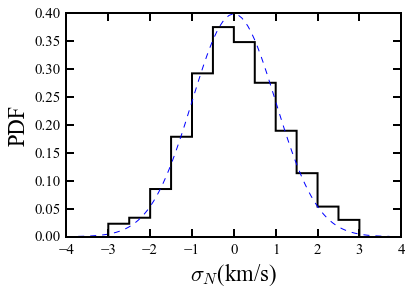

In [34]:
from scipy.stats import norm
from scipy import stats

sys = 0.3
diff = np.array(diff)
differr = np.array(differr)
diff = diff[differr<20]
differr = differr[differr<20]
print len(diff)

sig = diff/np.sqrt(differr**2+2*sys**2)
sig = stats.sigmaclip(sig,low=3., high=3.)[0]
plt.hist(sig,bins=12,normed=1, range=[-3.,3.], histtype='step',color='k',lw=2)
print np.mean(sig),np.std(sig)
x = np.linspace(norm.ppf(0.0001),norm.ppf(0.9999), 100)
plt.plot(x, norm.pdf(x),'--')
plt.xlabel('$\sigma_N$(km/s)')
plt.ylabel('PDF')
plt.show()

## Check how good the error estimation from the reduction
plot the relation between the mean fitting error from each single exposure (x-axis) and the standard deviation of v from multiple exposure (y-axis), red line is the one-to-one relation. No systematic floor is added.

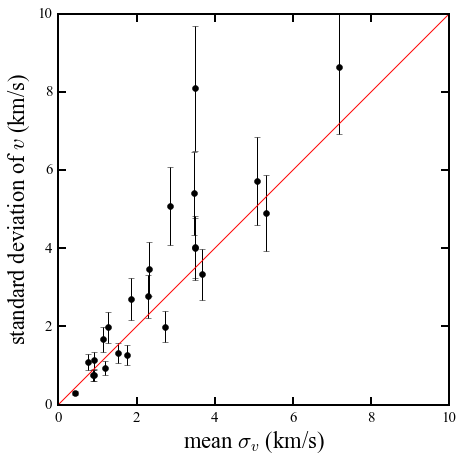

In [39]:
from scipy.stats import bayes_mvs

tab_all = [tab1, tab2, tab3, tab4, tab5, \
          tab6, tab7, tab8, tab9, tab10, \
          tab11, tab12, tab13, tab14]
targetlist = tab_all[0]['catalog_id']
maglist = tab_all[0]['rmag']
snrlist = tab_all[0]['snr']
k=0

plt.figure(figsize=[7,7])
#plt.xscale("log")
#plt.yscale("log")
for i in targetlist:
#for i in [4801595171326496768]:
    rvlist = []
    rverrlist = []
    for j in tab_all:
        idx = j['catalog_id'] == i
        if idx.any():
            #print i, j[idx]['rv'][0], j[idx]['rverr'][0]
            rvlist.append(j[idx]['rv'][0])
            rverrlist.append(j[idx]['rverr'][0])
    #plt.plot(maglist[k], np.std(sigmaclip(rvlist,low=3, high=3)[0]),'ro')
    #plt.plot(maglist[k], np.median(rverrlist),'gd')
    
    if np.mean(rverrlist) < 10:# and snrlist[k] > 2:
        #print i, np.mean(rverrlist), np.std(sigmaclip(rvlist,low=3, high=3)[0])
        temp = bayes_mvs(rvlist, alpha=0.68)[2]
        a = temp.statistic
        b = temp.statistic - temp.minmax[0] 
        c = temp.minmax[1] - temp.statistic
        #print a, b, c
        plt.errorbar(np.sqrt(np.mean(rverrlist)**2+0.3**2), a, yerr = np.vstack((b,c)),marker='o',color='k')
        #plt.plot(np.sqrt(np.mean(rverrlist)**2+0.**2), np.std(sigmaclip(rvlist,low=3, high=3)[0]),'+k',ms=10)
        #plt.plot(np.mean(rverrlist), np.std(rvlist),'+k',ms=10)        
    k += 1
    
plt.plot([0,20],[0,20],'r')
plt.ylim(0.,10)
plt.xlim(0.,10)
plt.xlabel('mean $\sigma_v$ (km/s)')
plt.ylabel('standard deviation of $v$ (km/s)')


## check the velocity error from single exposures and coadded exposure
red is the standard deviation from multiple single exposures
green is the mean fitting error from single exposures
cross is the fitting error from coadded spectra

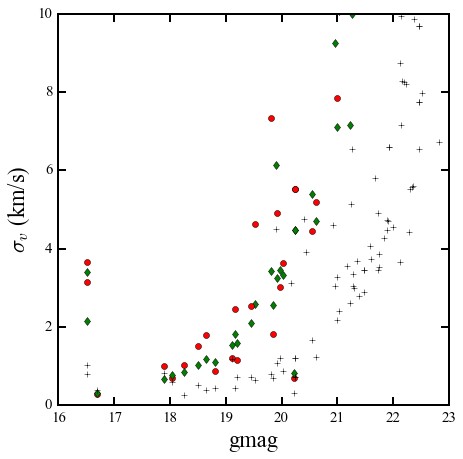

In [37]:
from scipy.stats import bayes_mvs

tab_all = [tab1, tab2, tab3, tab4, tab5, \
          tab6, tab7, tab8, tab9, tab10, \
          tab11, tab12, tab13, tab14]
targetlist = tab_all[0]['catalog_id']
maglist = tab_all[0]['rmag']
k=0

plt.figure(figsize=[7,7])
for i in targetlist:
    rvlist = []
    rverrlist = []
    for j in tab_all:
        idx = j['catalog_id'] == i
        if idx.any():
            #print i, j[idx]['rv'][0], j[idx]['rverr'][0]
            rvlist.append(j[idx]['rv'][0])
            rverrlist.append(j[idx]['rverr'][0])
    plt.plot(maglist[k], np.std(sigmaclip(rvlist,low=3, high=3)[0]),'ro')
    plt.plot(maglist[k], np.median(rverrlist),'gd')
    k += 1

master = np.genfromtxt('HorI_rv/HorI.txt', names=True, dtype=None)
maglist = master['rmag']
for i in targetlist:
    idx = master['catalog_id'] == i
    plt.plot(maglist[idx], master['rverr'][idx],'k+')   

#plt.plot([0,20],[0,20],'r')
plt.ylim(0,10)
#plt.xlim(0,10)
plt.xlabel('gmag')
plt.ylabel('$\sigma_v$ (km/s)')

# 33 potential members on the CMD. 
heliocentric velocity range for these 33 stars: 100-135 km/s, marked in red
prob > 0.01 marked in cyan 
M92 isochrone in blue lines. shifted to distance module = 19.7 

#ID, g, g-r
4801595171150140928 0.455652 21.9371
4801595171150146560 0.505852 21.5052
4801595171154699264 0.374302 22.2721
4801595171159822336 0.386379 22.8023
4801595171208309760 0.53981 20.385
4801595171178328064 0.421711 21.7055
4801595171178397696 0.449387 22.0445
4801595171178196992 -0.230186 20.1673
4801595171178200064 -0.086256 20.0798
4801595171178411520 0.463177 22.8276
4801595171178417664 0.454321 21.4855
4801595171178353664 0.496689 19.661
4801595171215208960 0.440136 21.6045
4801595171215221248 0.411501 22.0483
4801595171215892992 0.701117 18.5852
4801595171245123072 0.499796 21.0504
4801595171212473344 0.638369 19.4524
4801595171296285184 0.407427 22.5371
4801595171270981120 0.500095 21.116
4801595171270983680 0.481318 20.7193
4801595171270986240 0.532112 20.0523
4801595171270995968 0.989727 17.6856
4801595171271022080 0.590401 19.7056
4801595171271027200 0.687742 18.9929
4801595171311595520 -0.217432 20.2179
4801595171311606784 0.460392 21.8474
4801595171311610880 0.38155

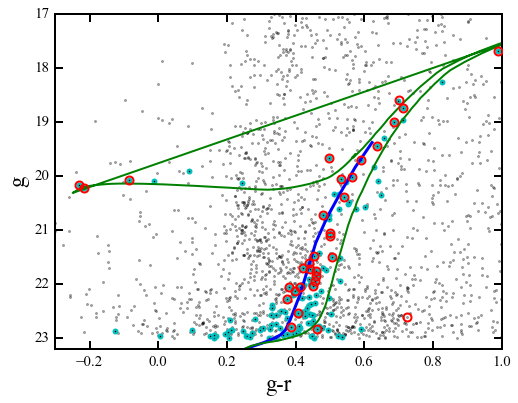

In [38]:
import pyfits 

fileroot = '../files/'
member = []
for lines in file('memberlist'):
    member.append(int(lines[:19]))

#member = [4801595171178353664]    
tbl = pyfits.open(fileroot+'horologium_i_mcmc_v3.fits')

#blue 
m92=np.loadtxt(fileroot+'m92_fiducial.dat',skiprows=1)
r_fiduc_m92=m92[:,0]
gmr_fiduc_m92=m92[:,2]

ubercal_zp_g_m92 = -0.013
ubercal_zp_r_m92 = -0.010
a_g_m92 = 0.072
a_r_m92 = 0.048
egr_m92 = a_g_m92 - a_r_m92
g0_fiduc_m92 = r_fiduc_m92 + gmr_fiduc_m92 + ubercal_zp_g_m92 - a_g_m92
r0_fiduc_m92 = r_fiduc_m92 + ubercal_zp_r_m92 - a_r_m92
gmr0_fiduc_m92 = gmr_fiduc_m92 + ubercal_zp_g_m92 - ubercal_zp_r_m92 - egr_m92
des_g0_fiduc_m92 =  g0_fiduc_m92 - 0.104*(gmr0_fiduc_m92) + 0.01
des_r0_fiduc_m92 = r0_fiduc_m92 - 0.102*(gmr0_fiduc_m92) + 0.02
iso=np.loadtxt(fileroot+'bressan12_12gyr_m2.2_des.dat')


plt.figure(figsize=[8,6])
plt.plot(tbl[1].data['WAVG_MAG_PSF_G']-tbl[1].data['WAVG_MAG_PSF_R'],tbl[1].data['WAVG_MAG_PSF_G'],'o',mec='k',mew=1,color='k',alpha=0.3,markersize=2)
mask = tbl[1].data['PROB'] > 0.01
plt.plot(tbl[1].data['WAVG_MAG_PSF_G'][mask]-tbl[1].data['WAVG_MAG_PSF_R'][mask],tbl[1].data['WAVG_MAG_PSF_G'][mask],'o',mec='c',mew=4,color='k',alpha=1,markersize=2)

print '#ID, g, g-r'
for i in range(len(tbl[1].data['CATALOG_ID'])):
    temp=tbl[1].data['CATALOG_ID'][i]
    if any(temp == np.array(member)):
        print temp, tbl[1].data['WAVG_MAG_PSF_G'][i]-tbl[1].data['WAVG_MAG_PSF_R'][i], tbl[1].data['WAVG_MAG_PSF_G'][i]
        plt.plot(tbl[1].data['WAVG_MAG_PSF_G'][i]-tbl[1].data['WAVG_MAG_PSF_R'][i],\
             tbl[1].data['WAVG_MAG_PSF_G'][i],'o',mfc ='None', mec='r',mew=2,markersize=8,zorder=5)

dm = 19.7
plt.plot(des_g0_fiduc_m92-des_r0_fiduc_m92, des_g0_fiduc_m92-14.59+dm,lw=3,color = 'b')
plt.plot(iso[:,9]-iso[:,10],iso[:,9]+dm, color='g',lw=2)

plt.xlim(-0.3,1.)     
plt.ylim(23.2,17)
plt.xlabel('g-r')
plt.ylabel('g')
plt.show()

# Histogram of observed stars in blue, histrogram of potential members in red (33 stars)

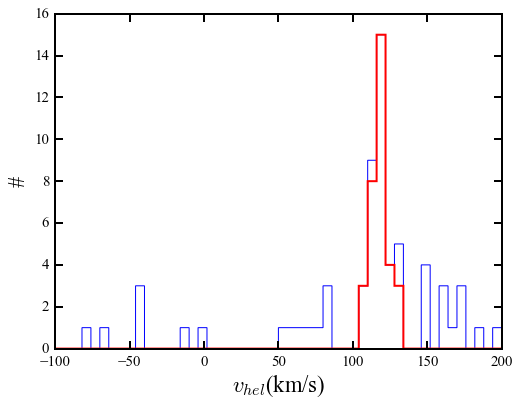

In [63]:
all_star = np.genfromtxt('HorI_rv/HorI_14exp_rv.txt',dtype=None, names=True)
member = np.genfromtxt('HorI_rv/HorI_14exp_member_rv.txt',dtype=None, names=True)

plt.figure(figsize=[8,6])
plt.hist(all_star['rv'],bins=50, range=[-100,200],histtype='step')
plt.hist(member['rv'],bins=50, range=[-100,200], color = 'r', histtype = 'step',lw=2)
plt.ylabel('#')
plt.xlabel('$v_{hel}$(km/s)')

## velocity dispersion calculated based on 27 members. If all 33 members are included then the velocity dispersion is around 5.1+/-1.0 km/s

# of members =27


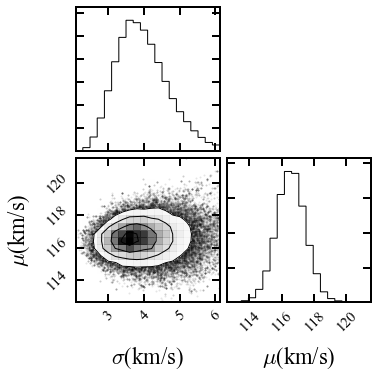

# of members =27
velocity for median,  +34%, -34%
(116.57398240761808, 0.90141660521450717, -0.88011931143128663)
dispersion for  median, +34%, -34%
(3.8914993508075209, 0.80960074898149381, -0.63670188970205244)


In [27]:
execfile('/Users/astrolab/Dropbox/dwarfgalaxy/RVmcmc/mcmc_sigma2_mean_arxiv_compare.py')